# CSCI-GA 3033-076 Vision Meets Machine Learning
## Homework 4

Enter your name and NetID below.

#### Name: Ankit Sati
#### NetID: as14128

### Goals

In this assignment, you will implement monocular depth estimation.

The goals of this assignment are as follows:

- Understand monocular depth estimation
- Implement depth estimation using ranking loss based on relative depth.

**Please ensure that all visualizations are clearly visible in your final submission. Failure to do so would result in a deduction of points.**

# 1. Introduction to depth estimation

Depth estimation is a crucial aspect of computer vision that involves determining the distance or depth of objects in a scene from single or multiple images. This task is essential for various applications such as robotics, autonomous vehicles, virtual reality, and 3D reconstruction. Traditional techniques like stereo vision or time-of-flight sensors were employed to measure depth. However, recent advancements in deep learning and convolutional neural networks (CNNs) have led to more accurate and efficient depth estimation methods, particularly using monocular images.

One of the most prominent approaches in depth estimation using deep learning is supervised learning, where a CNN is trained on a dataset of RGB images paired with corresponding ground truth depth maps. This process allows the network to learn a mapping from the input image to the depth map, enabling accurate depth estimation for a wide range of scenes and objects.

# 2. Depth estimation

Metric depth estimation aims to estimate the actual depth or distance of objects in a scene from a single image or a sequence of images. This technique is vital for applications such as autonomous navigation, robotics, and augmented reality. Metric depth estimation methods can be broadly classified into supervised and unsupervised categories. Supervised methods leverage ground truth depth maps obtained from depth sensors or generated synthetically, while unsupervised methods rely on geometric constraints and multiple views of the scene to infer depth information.

In contrast, relative depth estimation focuses on determining the depth ordering of objects in a scene without providing the actual metric depth values. This approach is useful in scenarios where precise depth information is not required, and the primary goal is to understand the spatial relationships between objects. 

Deep learning techniques, specifically CNNs, have been employed to tackle depth estimation. These methods often involve training a CNN to learn a representation that captures the ordinal depth relationship between different regions in an image. Supervised approaches use datasets with labeled pairs of image regions, while self-supervised methods utilize geometric or semantic cues present in the scene to predict relative depth without relying on labeled data. Recent research has led to more robust and efficient techniques for depth estimation, exploring strategies such as incorporating multi-scale features, leveraging scene semantics, or using attention mechanisms to improve performance.

Please provide your responses in the allocated spaces. This assignment consists of a combination of theoretical and programming questions. You can quickly navigate to coding questions by searching (Ctrl/Cmd-F) for `TODO:`. Similarly, the theoretical questions can be found by searching for `[WRITE_ANSWER_HERE]`.

### Question 1 [5%]

Provide a scenario in which estimating metric depth is more advantageous than relative depth estimation. Explain why.

Answer :

Metric depth estimates are superior to relative depth estimates in circumstances when a precise understanding of depth is necessary for the task at hand. For instance, in autonomous navigation, an accurate calculation of the distance between the vehicle and nearby objects is necessary for safe navigation. Similar to this, precise depthinformation is necessary to organize and carry out manipulation activities in robotics applications. In many cases, relative depth information which only indicates where objects are in an image without providing actualmetric depth values might not be sufficient. Therefore, it is better to estimate metric depth in these circumstances in order to achieve a greater degree of precision and accuracy.

## Prepare data

In this assignment, you will be working on a relative depth dataset based on the NYU Depth Dataset V2, which is a widely used dataset for depth estimation and computer vision tasks. The NYU Depth Dataset V2 contains a large set of RGB-D images captured in various indoor environments, providing both color images and corresponding depth maps. For the purpose of this assignment, we use the dataset released by [Single-Image Depth Perception in the Wild](http://www-personal.umich.edu/~wfchen/depth-in-the-wild/) project.

In [35]:
from PIL import Image
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

In [36]:
data_path = Path('../shared/data/HW4/NYU')
processed_data_path = Path('./processed')
processed_data_path.mkdir(exist_ok=True)

## Preprocess the data

### Question 2  [5%]

In [37]:
def convert_relative_depth(depth_symbol):
    """Converts a relative depth symbol to a numerical value.

    Args:
        depth_symbol (str): A string representing the relative depth.

    Returns:
        int: The numerical value of the relative depth. '>' is 1, '<' is -1, and any other character is 0.
    """
    # TODO: Implement the following method based on the docstring above.
    # *** START OF SOLUTION ***
    if depth_symbol == '<':
        return -1
    elif depth_symbol == '>':
        return 1
    else:
        return 0
    # *** END OF SOLUTION ***

In [38]:
# Test cases for question 1
assert convert_relative_depth('>') == 1
assert convert_relative_depth('<') == -1
assert convert_relative_depth('=') == 0


Initially, we shall investigate the dataset. The ground truth CSV file has a non-conventional format. Each row describes an image, followed by subsequent rows that convey ordinal relationships between pairs of points within the image. This pattern is repeated for each image in the specified split of the dataset.

In [39]:
files = ['750_train_from_795_NYU_MITpaper_train_imgs_800_points_resize_240_320.csv',
         '654_NYU_MITpaper_test_imgs_orig_size_points.csv']
is_original_size = [False, True]

In [40]:
df = pd.read_csv(data_path / files[0])
df.head()

,Img Filename,Depth Filename,coord_A,coord_B,Relationship
0,../../data/795_NYU_MITpaper_train_imgs/349.png,dummy_depth_filename,800,dummy,dummy
1,1,4,16,4,>
2,1,4,7,14,<
3,16,4,27,7,>
4,16,4,98,2,>


### Question 3 [5%]

In [41]:
def convert_labels(path, is_original_size = False):
    # Read the CSV file into a DataFrame, skipping the first row
    raw_labels = pd.read_csv(path, header=None, skiprows=1)

    # Extract the rows containing file paths (starting with '.')
    names = raw_labels[raw_labels[0].apply(lambda x: x[0] == '.')]

    # Apply the convert_depth function to the ordinal depth values (column index 4)
    raw_labels[4] = raw_labels[4].apply(convert_relative_depth)

    labels = []

    for i in range(len(names.index)):
        # Determine the range of rows in raw_labels corresponding to the current name
        if i + 1 >= len(names.index):
            points = raw_labels[names.index[i] + 1:].values.astype('float32')
        else:
            points = raw_labels[names.index[i] + 1:names.index[i + 1]].values.astype('float32')

        # Create a dictionary to store the processed label attributes
        # TODO: Replace the None types below with the correct items from points 
        # (example, points[:, ..] where .. should be filled) 
        # Hint: Observe the format of the csv file in the previous cell.
        # Hint: Use split method to extract filename from path.
        # *** START OF SOLUTION ***
        filepath = names.iloc[i][0]
        filename = filepath.split('/')[-1]
        label = {
            'filename': filename, # Extract the filename from the file path
            'x_A': points[:, 0], # x-coordinates of points A
            'y_A': points[:, 1], # y-coordinates of points A
            'x_B': points[:, 2], # x-coordinates of points B
            'y_B': points[:, 3], # y-coordinates of points B
            'ordinal_relation': points[:, 4] # ordinal depth values
        }
        # *** END OF SOLUTION ***

        # Skip the current iteration if the number of points is not equal to 800 (train dataset has 800 annotations)
        if not is_original_size and len(points) != 800:
            print(f"Skipping label {i} with {len(points)} points")
            continue

        # Append the processed label to the labels list
        labels.append(label)
    return labels


In [42]:
def save_object(obj, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)

def load_object(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

for file, is_orig_size in zip(files, is_original_size):
    labels = convert_labels(data_path / file, is_orig_size)
    save_object(labels, processed_data_path / (file.split('.')[0] + '.pkl'))
    print(f'Saved {file.split(".")[0]}.pkl')

Skipping label 77 with 759 points
Skipping label 243 with 674 points
Skipping label 282 with 752 points
Skipping label 499 with 734 points
Skipping label 680 with 770 points
Saved 750_train_from_795_NYU_MITpaper_train_imgs_800_points_resize_240_320.pkl
Saved 654_NYU_MITpaper_test_imgs_orig_size_points.pkl


# Create a dataloader

In this step, you will create a dataloader to efficiently load and preprocess the relative depth dataset based on the NYU Depth Dataset V2. The dataloader will be responsible for reading the image pairs and corresponding relative depth labels, applying necessary preprocessing transformations, and generating data batches for training and evaluation.

### Question 4 [10%]

In [43]:
import os
from torch.utils.data import Dataset
from torchvision.transforms import transforms

class RelativeDepthDataset(Dataset):
    def __init__(self, path_to_images, path_to_targets, input_transforms=None):
        self.path_to_images = path_to_images
        with open(path_to_targets, 'rb') as f:
            self.targets = pickle.load(f)
        self.imgs = [target['filename'] for target in self.targets]
        self.transforms = input_transforms or transforms.ToTensor()

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        # TODO: Replace the None types below with the correct items from self.targets and load the corresponding image
        # *** START OF SOLUTION ***
        target = self.targets[index]
        img_path = os.path.join(self.path_to_images, target['filename'])
        img = Image.open(img_path).convert("RGB")
        img = self.transforms(img)
        #This is the main image that will be transformed 
        # *** END OF SOLUTION ***

        return img, target


### Question 5 [5%]

In [44]:
path_train_img = data_path / '795_NYU_MITpaper_train_imgs'
path_train_target = processed_data_path / '750_train_from_795_NYU_MITpaper_train_imgs_800_points_resize_240_320.pkl'

# TODO: Create the training dataset
# *** START OF SOLUTION ***
train_dataset = RelativeDepthDataset(str(path_train_img),str(path_train_target))
# *** END OF SOLUTION ***

# Visualize sample inputs

Now that you have implemented the dataloader for the relative depth dataset, it's essential to visualize some sample inputs to ensure that the data is loaded and preprocessed correctly. Visualizing sample inputs will also provide you with a better understanding of the dataset's characteristics, enabling you to make more informed decisions when designing and tuning your depth estimation models.

### Question 6 [5%]

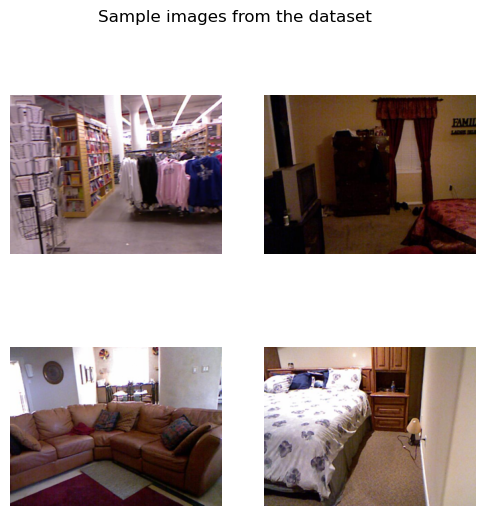

In [45]:
import random
import matplotlib.pyplot as plt
# TODO: Construct samples list which consists of 4 random input images from the train_dataset
# Hint: Use random.sample method
# *** START OF SOLUTION ***
# This could be improved as shown in question 11.
samples = random.sample(list(train_dataset), 4)
# *** END OF SOLUTION ***
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
fig.suptitle("Sample images from the dataset")
for i, sample in enumerate(samples):
    row = i // 2
    col = i % 2
    #axs[row][col].imshow(sample[0].permute(1, 2, 0)) # init was: imshow(sample.permute) which was throwing error. Added [0]
    axs[row][col].imshow(sample[0].permute(1, 2, 0))
    axs[row][col].axis('off')
# Show the figure
plt.show()


## Model definiton

In this stage, we see an hourglass model based on the Inception architecture for depth estimation. The Inception architecture is known for its ability to efficiently capture multi-scale features in images, making it a suitable choice for depth estimation tasks. By combining the hourglass design, which excels at maintaining spatial information while aggregating features from different scales, we create a powerful model for predicting relative depth from image pairs. This is based on the original research in [Chen et al](http://www-personal.umich.edu/~wfchen/depth-in-the-wild/). For better results, especially if needed for a research or product, we could also consider using ResNet or Vision Transformers as the backbone architecture, as they have demonstrated strong performance in various computer vision tasks.

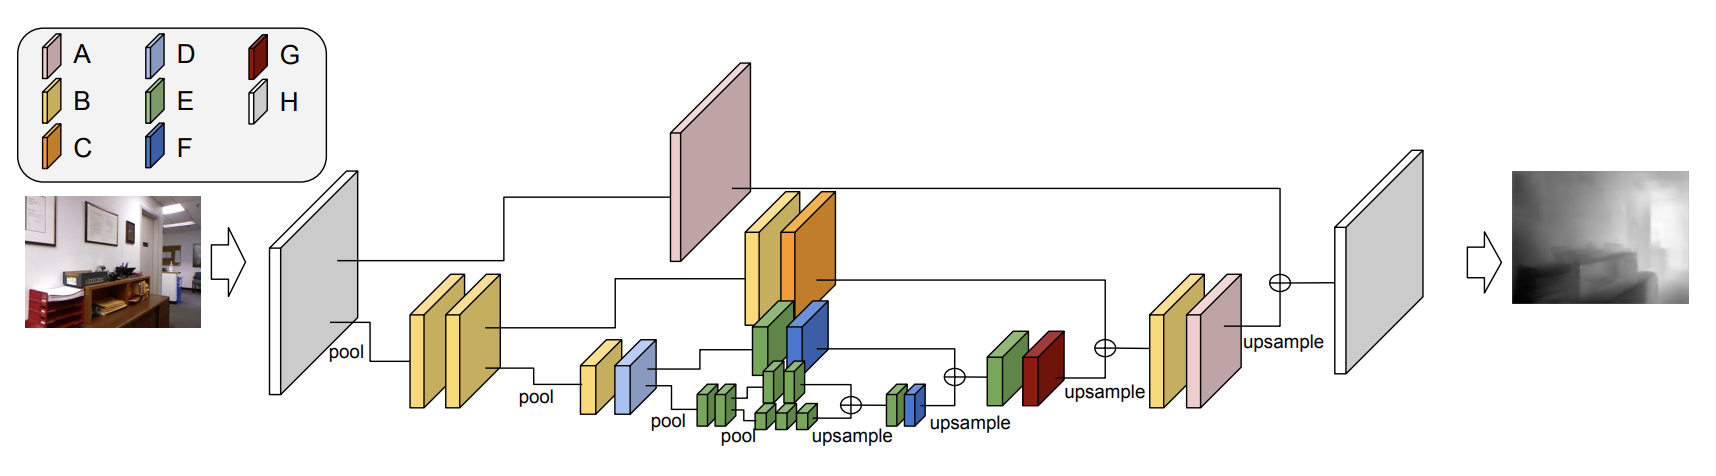

In [46]:
import torch
from torch import nn
import torch.nn.functional as F


class ConvReluBN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(ConvReluBN, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x, True)
        return self.bn(x)


class InceptionS(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(InceptionS, self).__init__()

        # Calculate filters per branch
        branch_out_channels = int(out_channels / 4)

        # Initialize convolutional layers for each branch
        self.conv1x1 = ConvReluBN(in_channels, branch_out_channels, kernel_size=1)
        self.conv3x3 = ConvReluBN(branch_out_channels, branch_out_channels, kernel_size=3, padding=1)
        self.conv5x5 = ConvReluBN(branch_out_channels, branch_out_channels, kernel_size=5, padding=2)
        self.conv7x7 = ConvReluBN(branch_out_channels, branch_out_channels, kernel_size=7, padding=3)

    def forward(self, x):
        # Branch with 1x1 filter
        branch1x1 = self.conv1x1(x)

        # Branch with 3x3 filter
        branch3x3 = self.conv1x1(x)
        branch3x3 = self.conv3x3(branch3x3)

        # Branch with 5x5 filter
        branch5x5 = self.conv1x1(x)
        branch5x5 = self.conv5x5(branch5x5)

        # Branch with 7x7 filter
        branch7x7 = self.conv1x1(x)
        branch7x7 = self.conv7x7(branch7x7)

        # Concatenate branches along the channel dimension
        output = torch.cat([branch1x1, branch3x3, branch5x5, branch7x7], dim=1)

        return output


class InceptionL(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(InceptionL, self).__init__()

        # Calculate filters per branch
        branch_out_channels = int(out_channels / 4)

        # Initialize convolutional layers for each branch
        self.conv1x1 = ConvReluBN(in_channels, branch_out_channels, kernel_size=1)
        self.conv3x3 = ConvReluBN(branch_out_channels, branch_out_channels, kernel_size=3, padding=1)
        self.conv7x7 = ConvReluBN(branch_out_channels, branch_out_channels, kernel_size=7, padding=3)
        self.conv11x11 = ConvReluBN(branch_out_channels, branch_out_channels, kernel_size=11, padding=5)

    def forward(self, x):
        # Branch with 1x1 filter
        branch1x1 = self.conv1x1(x)

        # Branch with 3x3 filter
        branch3x3 = self.conv1x1(x)
        branch3x3 = self.conv3x3(branch3x3)

        # Branch with 7x7 filter
        branch7x7 = self.conv1x1(x)
        branch7x7 = self.conv7x7(branch7x7)

        # Branch with 11x11 filter
        branch11x11 = self.conv1x1(x)
        branch11x11 = self.conv11x11(branch11x11)

        # Concatenate branches along the channel dimension
        output = torch.cat([branch1x1, branch3x3, branch7x7, branch11x11], dim=1)

        return output



class HourGlass(nn.Module):
    def __init__(self):
        super(HourGlass, self).__init__()

        # Define constants
        A_in_channels = 128
        A_out_channels = 64
        B_in_channels = 128
        B_out_channels = 128
        C_in_channels = 128
        C_out_channels = 128
        D_in_channels = 128
        D_out_channels = 256
        E_in_channels = 256
        E_out_channels = 256
        F_in_channels = 256
        F_out_channels = 256
        G_in_channels = 256
        G_out_channels = 128
        H_in_channels = 3
        H_out_channels = 128
        I_in_channels = 64
        scale_factor = 2

        self.batch_norm = nn.BatchNorm2d(3)
        self.avg_pool = nn.AvgPool2d(scale_factor)
        self.max_pool = nn.MaxPool2d(scale_factor)
        self.upsample = nn.Upsample(scale_factor=scale_factor)
        self.A = InceptionL(A_in_channels, A_out_channels)
        self.B = InceptionS(B_in_channels, B_out_channels)
        self.C = InceptionL(C_in_channels, C_out_channels)
        self.D = InceptionS(D_in_channels, D_out_channels)
        self.E = InceptionS(E_in_channels, E_out_channels)
        self.F = InceptionL(F_in_channels, F_out_channels)
        self.G = InceptionS(G_in_channels, G_out_channels)
        self.H = ConvReluBN(H_in_channels, H_out_channels, kernel_size=7, padding=3)
        self.I = nn.Conv2d(I_in_channels, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Normalize input
        x = self.batch_norm(x)

        # Apply initial ConvReluBN layer
        x = self.H(x)

        # Channel 1
        channel1 = self.A(x)

        # Channel 2
        channel2_input = self.avg_pool(x)
        channel2 = self.B(channel2_input)
        channel2 = self.B(channel2)

        # Channel 3
        channel3_input = self.avg_pool(channel2)
        channel3 = self.B(channel3_input)
        channel3 = self.D(channel3)

        # Channel 4
        channel4_input = self.max_pool(channel3)
        channel4 = self.E(channel4_input)
        channel4 = self.E(channel4)

        # Channel 5
        channel5_input = self.max_pool(channel4)
        channel5 = self.E(channel5_input)
        channel5 = self.E(channel5)
        channel5 = self.E(channel5)
        channel5_upsampled = self.upsample(channel5)

        # Second half of Channel 4
        channel4 = self.E(channel4)
        channel4 = self.E(channel4)
        channel4 = channel4 + channel5_upsampled
        channel4 = self.E(channel4)
        channel4 = self.F(channel4)
        channel4_upsampled = self.upsample(channel4)

        # Second half of Channel 3
        channel3 = self.E(channel3)
        channel3 = self.F(channel3)
        channel3 = channel4_upsampled + channel3
        channel3 = self.E(channel3)
        channel3 = self.G(channel3)
        channel3_upsampled = self.upsample(channel3)

        # Second half of Channel 2
        channel2 = self.B(channel2)
        channel2 = self.C(channel2)
        channel2 = channel3_upsampled + channel2
        channel2 = self.B(channel2)
        channel2 = self.A(channel2)
        channel2_upsampled = self.upsample(channel2)

        # Combine Channel 1 and Channel 2
        combined_channels = channel2_upsampled + channel1

        # Apply final Conv2d layer
        output = self.I(combined_channels)

        return output


## Training the model

### Question 7 [30%]

In [47]:
class RelativeDepthLoss(nn.Module):
    def __init__(self):
        super(RelativeDepthLoss, self).__init__()

    def ranking_loss(self, z_A, z_B, target):
        """
        Computes the ranking loss for a given set of pixels:
        z_A: Predicted absolute depth for pixels A
        z_B: Predicted absolute depth for pixels B
        target: Relative depth between A and B (-1, 0, 1)
        """
        pred_depth = z_A - z_B

        # TODO: Implement the loss function below.
        # It is optional to use the starter code given below. 
        # It is enough to ensure log_loss and squared_loss are implemented correctly.
        # *** START OF SOLUTION ***
        # Calculate the log loss for non-zero targets
        non_zero_mask = (target != 0)
        non_zero_targets = target[non_zero_mask]
        non_zero_pred_depth = pred_depth[non_zero_mask]
        weighted_pred_depth = -1 * non_zero_pred_depth * non_zero_targets 
        exp_weighted_pred_depth = torch.exp(weighted_pred_depth)
        loss_term = torch.log(1 + exp_weighted_pred_depth)
        log_loss = torch.mean(loss_term)

        # Calculate the squared loss for zero targets
        zero_targets = (target == 0).float()
        squared_loss = torch.mean(zero_targets * pred_depth**2)
        
        # *** END OF SOLUTION ***

        # Return the sum of the log loss and squared loss
        return log_loss + squared_loss


    def forward(self, output, target):
        total_loss = 0
        for index in range(len(output)):
            x_A = target['x_A'][index].long()
            y_A = target['y_A'][index].long()
            x_B = target['x_B'][index].long()
            y_B = target['y_B'][index].long()

            # All "A" points
            z_A = output[index][0][x_A, y_A]
            # All "B" points
            z_B = output[index][0][x_B, y_B]

            total_loss += self.ranking_loss(z_A, z_B, target['ordinal_relation'][index])

        return total_loss / len(output)

In [48]:
from tqdm import tqdm
from torch.utils.data import DataLoader

def prep_img(img, device):
    return img.unsqueeze(0).to(device)

def fit(model, train, criterion, optimizer, device, batch_size=32, shuffle=True, nb_epoch=1, num_workers=0):
    print(f'Train on {len(train)} samples')

    train_loader = DataLoader(train, batch_size, shuffle, num_workers=num_workers, pin_memory=True)

    for epoch in tqdm(range(nb_epoch), total=nb_epoch):
        model.train()
        running_loss = 0.0
        num_batches = 0
        t = tqdm(train_loader, total=len(train_loader))

        for data, target in t:
            data = data.to(device)
            target['x_A'] = target['x_A'].to(device)
            target['y_A'] = target['y_A'].to(device)
            target['x_B'] = target['x_B'].to(device)
            target['y_B'] = target['y_B'].to(device)
            target['ordinal_relation'] = target['ordinal_relation'].to(device)
            output = model(data)
            loss = criterion(output, target)
            running_loss += (loss_item := loss.item())
            num_batches += 1
            avg_loss = running_loss / num_batches
            t.set_description(f"[ Loss: {avg_loss:.4f} ]")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

## Training the model

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = HourGlass().to(device)

Using device: cuda


### Question 8 [5%]

Based on what you learnt in the course, how would you improve the model we used here? Provide two approaches and explain the rationale behind each of the approach.

<b>Answer</b>
In class there were many techniques that were mentioned but I found a few different models to improve the approach that is used in this notebook.

 <b>1. skip connections:</b> In the UNet architecture used in this notebook, the encoder and decoder layers are linked together via skip connections. By preserving spatial information that was lost during the encoding process, the model's accuracy may be improved by leveraging these linkages. Additional skip connections or the use of other techniques might improve the model even more. There are a few drawbacks that I will mention in the conclusion.
 
  <b>2. Impact of a deeper network:</b> With only 18 layers, the ResNet18 network utilized in this notebook is quite small. Deeper models are capable of learning more intricate information from the input pictures, which can enhance performance. Deeper networks can be more susceptible to overfitting and are more computationally costly. Using regularization methods like dropout or weight decay is one way to reduce overfitting.
  
  <b>Conclusion</b>
The technique chosen is determined by the application's unique needs and the available computational resources. If accuracy is the major objective, a deeper network may be preferable, but skip connections may be preferable if spatial information preservation is more essential.
  

### Question 9 [15%]

In [50]:
# TODO: Create and configure a optimizer and the loss function.
# *** START OF SOLUTION ***
import torch
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = RelativeDepthLoss()
# *** END OF SOLUTION ***

batch_size = 8
fit(model, train_dataset, criterion, optimizer, device, batch_size, nb_epoch=40)

Train on 745 samples


100%|██████████| 40/40 [50:30<00:00, 75.76s/it]


### Question 10 [5%]

If you were given access to metric depth information as part of the ground truth, what additional loss function components would you consider incorporating? Explain why.

<b>Answer</b>

There are a few additional loss function components that could be incorporated. Most of them might not factor in much but the initial two could have a significant impact. Also, There are a few white papers that were recemtly released in the Berkley Journal and I would mention about them in the end.

<b>1. Cross-entropy loss:</b>
Cross-entropy loss is a commonly used loss function in machine learning and deep learning, particularly for classification tasks. It measures the dissimilarity between predicted probabilities and the true labels of a dataset. By calculating the logarithmic loss of the predicted probabilities, cross-entropy loss quantifies the information gained or lost during the classification process. It is often used as an objective function to optimize the parameters of a model through methods like gradient descent.

<b>2. Scale-Invariant Loss:</b>
Considering metric depth information indicates the absolute scale of the image, incorporating a scale-invariant loss component may be beneficial. This loss helps to resolve the scale ambiguity problem in depth estimation, in which the model predicts correct relative depths but incorrect absolute scales. By introducing a scale-invariant loss, the model is encouraged to estimate depths.

Example :- Many geological phenomena are scale invariant. Examples include the frequency-size distributions of rock fragments, faults, earthquakes, volcanic eruptions, and oil fields.

<b>3. Depth Regression Loss:</b>
By comparing the projected depth values to the ground truth metric depth values, the depth regression loss can be computed. This loss helps the model to estimate the absolute depth of the picture appropriately. The model may learn to create depth maps that closely correlate with the real metric depth values by including depth regression loss, resulting in more accurate depth estimate.

<b>Conclusion and white papers</b>
Incorporating these additional loss components helps to leverage the available metric depth information to guide the model towards more accurate and reliable depth estimation. The depth regression loss ensures accurate absolute depth estimation, the scale-invariant loss addresses scale ambiguity, and the depth smoothness loss promotes smooth and coherent depth maps. Together, these components contribute to improving the performance and robustness of the depth estimation model.


# Visualize output predictions

After training the depth estimation model, it's important to visualize the output predictions for random samples from the test set. This step will help you evaluate the model's performance, identify any issues or biases, and gain insights into its generalization capabilities.

**Please ensure the output predictions are visible in your final submission. Failure to do so would result in a deduction of points.**

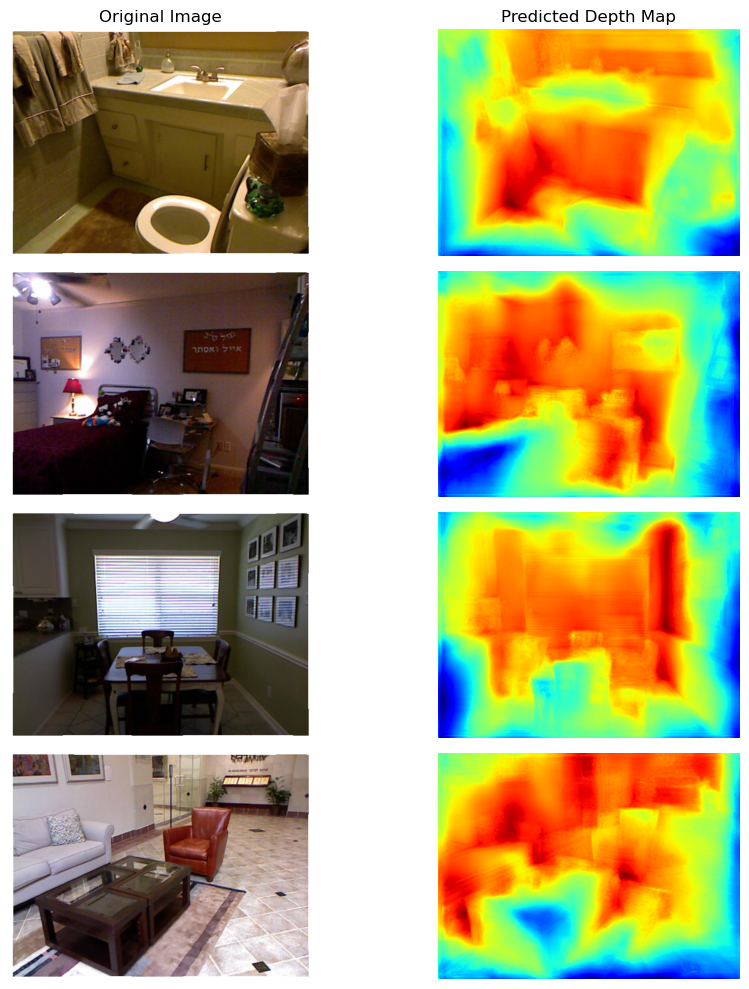

In [51]:
path_test_img = data_path / '654_NYU_MITpaper_test_imgs_orig_size'
path_test_target = processed_data_path / '654_NYU_MITpaper_test_imgs_orig_size_points.pkl'

test_dataset = RelativeDepthDataset(path_test_img, path_test_target)

num_images = 4
fig, axs = plt.subplots(num_images, 2, figsize=(10, 10))

for i in range(num_images):
    idx = random.randint(0, len(test_dataset) - 1)
    image, _ = test_dataset[idx]
    original = image.numpy().transpose(1, 2, 0)
    out = model(prep_img(image, device))

    axs[i, 0].imshow(original)
    axs[i, 0].axis('off')
    predicted_depth = out.data.cpu().numpy().squeeze()
    axs[i, 1].imshow(predicted_depth, cmap='jet')
    axs[i, 1].axis('off')

axs[0, 0].set_title('Original Image')
axs[0, 1].set_title('Predicted Depth Map')
plt.tight_layout()
plt.show()

### Question 11 [10%]

In order to enhance the quality of predictions, what are two possible methods you would consider implementing? Please provide a brief explanation for each approach.



<b>Answer</b>
I will discuss two techniques in lenght below. One of them is more widely used and I will show an usecase to explain why that is the case.
<b>1. Post-processing and Ensemble Methods:</b>
To increase the accuracy of depth estimates, post-processing methods can be used. These strategies seek to improve the original depth estimations by utilizing more data or employing particular algorithms. Depth map filtering and holefilling are two typical post-processing approaches. Depth map filtering techniques such as bilateral filtering/guided filtering can be used to eliminate noise from depth maps and enhance overall smoothness. Sharp edges can be preserved while noise is reduced using edge-preserving smoothing techniques such as total variation regularization. Based on the surrounding information, hole-filling algorithms can be used to fill missing or erroneous depth measurements. The depth maps may be improved in terms of noise reduction, edge preservation, and completeness by combining various post-processing and refinement procedures, resulting in more aesthetically appealing and accurate predictions.

Ensemble approaches integrate numerous separate models to create predictions, which frequently results in better performance than using a single model. Bagging and boosting are two prominent ensemble techniques. Bagging entails separately training several models on distinct subsets of the training data and averaging their predictions. This can assist decrease overfitting and improve model generalization. Boosting, on the other hand, is concerned with iteratively training weak models that are successively developed to repair prior models' errors. Methods for boosting, such as AdaBoost and gradient boosting, can efficiently combine the capabilities of many models to deliver more accurate predictions.

<b>2. Feature Engineering:</b>
Feature engineering involves transforming or creating new features from the existing raw data to improve the predictive power of a model. This process can include techniques such as scaling, normalization, polynomial expansion, dimensionality reduction, and creating interaction terms. By extracting relevant information from the data and representing it in a more suitable form, feature engineering can help the model capture complex patterns and relationships that may not be apparent in the raw data alone.

Another way includes incorporating information from multiple scales or resolutions to improve the accuracy and detail in depth predictions. This can be achieved by employing a multi-scale architecture or using multi-scale features. One approach is to use a pyramid-like structure where the input image is processed at different scales, and the features from each scale are fused together to generate a final prediction. This allows the model to capture both global context and fine-grained details, leading to more accurate and detailed depth maps. Another approach is to use feature fusion techniques, such as skip connections or feature concatenation, to combine features from different scales or layers in the network.

<b>2. Conlclusion</b>
The quality of depth forecasts may be considerably enhanced by adding multi-scale fusion and post-processing/refinement methods. The model can collect both global and local information thanks to Feature Engineering, resulting in more accurate and precise depth maps. Post-processing and refinement approaches improve the predictions even further by decreasing noise, maintaining edges, and filling in missing data, resulting in higher-quality depth estimate outputs. It's important to note that the specific methods to employ depend on the nature of the data, the problem at hand, and the algorithms being used.

## References

* Single-Image Depth Perception in the Wild ([1](http://www-personal.umich.edu/~wfchen/depth-in-the-wild/),[2](https://arxiv.org/abs/1604.03901),[3](https://github.com/princeton-vl/relative_depth),[4](https://github.com/A-Jacobson/Depth_in_The_Wild),[5](https://github.com/yifjiang/relative-depth-using-pytorch))
* Monocular Relative Depth Perception with Web Stereo Data Supervision ([1](https://openaccess.thecvf.com/content_cvpr_2018/papers/Xian_Monocular_Relative_Depth_CVPR_2018_paper.pdf))